## Demo 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

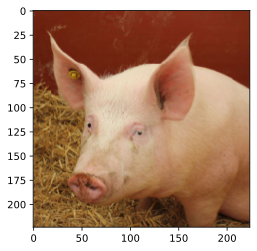

In [2]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [4]:
# form predictions
pred = model(norm(pig_tensor))

In [5]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(pred.max(dim=1)[1].item())
print(imagenet_classes[pred.max(dim=1)[1].item()])

341
hog


In [6]:
# 341 is the class index corresponding to "hog"
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

0.003882253309711814


A loss of 0.0039 is pretty small: by the conventions above, that would correspond to an $\exp(-0.0039) \approx 0.996$ probability that the classifier believes this to be a pig.

### cross entropy loss: 

![title](crossentropy.png)

### PGD Attack

In [7]:
#Attack
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.003882253309711814
5 -0.006934622768312693
10 -0.01582128368318081
15 -0.08061302453279495
20 -11.138195037841797
25 -13.789603233337402
True class probability: 4.006724196869982e-08


After 30 gradient steps, the ResNet50 thinks that this has less than a $10^{-5}$ chance of being a pig.  (Note: we should also clip $x + \delta$ to be in $[0,1]$, but this already holds for any $\delta$ within the above bound, so we don't need to do it explicitly here).  Instead, it turns out that this classifier is quite sure the image is a wombat, as we can see from the following code, which computes the maximum class and its probability.

In [8]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  wombat
Predicted probability: 0.9999737739562988


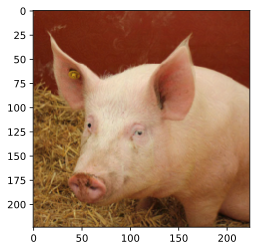

In [9]:
#wombatpig
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

Here in fact is the `delta` we added to the image, heavily zoomed in by a factor of 50 because it would be impossible to see otherwise.

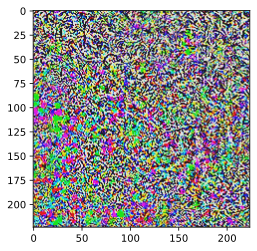

In [10]:
#wombatnoise
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

### FGSM Attack

In [11]:
epsilon = 2./255

delta_fgsm = torch.zeros_like(pig_tensor, requires_grad=True)

pred = model(norm(pig_tensor + delta_fgsm))
loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
grad = torch.autograd.grad(loss,delta_fgsm, retain_graph=False, create_graph=False)[0]
# gradient ascent
delta_fgsm = delta_fgsm + epsilon*grad.sign()  
pred = model(norm(pig_tensor + delta_fgsm))

print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

True class probability: 0.398336797952652


adversarial image

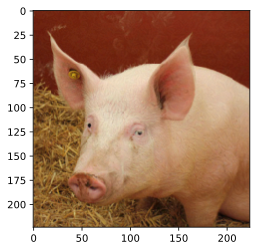

In [12]:
plt.imshow((pig_tensor + delta_fgsm)[0].detach().numpy().transpose(1,2,0))

noise

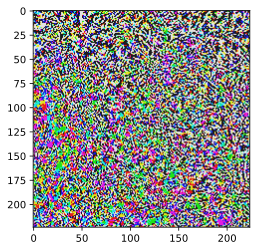

In [13]:
plt.imshow((50*delta_fgsm+0.5)[0].detach().numpy().transpose(1,2,0))

### Defense

#### Add random noise to the adversarial generated by PGD Attack

In [21]:
sigma = 0.05
random_noise = sigma*torch.randn_like(pig_tensor)
print(random_noise[0][0])
pred = model(norm(pig_tensor + delta + random_noise))
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

tensor([[-0.0228, -0.0383,  0.0440,  ...,  0.0040,  0.0339, -0.0463],
        [ 0.0073,  0.0110, -0.0228,  ...,  0.1166, -0.0116, -0.0260],
        [ 0.0298, -0.0280, -0.0428,  ..., -0.0194,  0.0206,  0.0388],
        ...,
        [-0.0282, -0.0525,  0.0164,  ...,  0.0391, -0.0174, -0.0714],
        [ 0.0145, -0.0064, -0.0005,  ..., -0.0159, -0.0297,  0.0370],
        [-0.0414, -0.0550, -0.0293,  ..., -0.0015,  0.0342, -0.0376]])
True class probability: 0.996437668800354


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


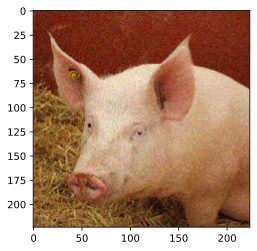

In [15]:
plt.imshow((pig_tensor + delta_fgsm + random_noise)[0].detach().numpy().transpose(1,2,0))

success defended the attack 50 times consecutively 

#### Add random noise to the adversarial generated by FGSM Attack

In [22]:
sigma = 0.05
random_noise = sigma*torch.randn_like(pig_tensor)
pred = model(norm(pig_tensor + delta_fgsm + random_noise))
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

True class probability: 0.9907761216163635


### Target PGD Attack

In [23]:
#Target Attack
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 24.006052017211914
10 -0.0302581787109375
20 -8.336313247680664
30 -14.290587425231934
40 -21.1085262298584
50 -25.596567153930664
60 -30.899789810180664
70 -32.22068405151367
80 -38.764102935791016
90 -40.17652893066406


In [24]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.956876277923584


As before, here's our airliner-pig, looking an awful lot like a normal pig (the target class of 404 from the code is indeed an airliner, so our targeted attack is working)

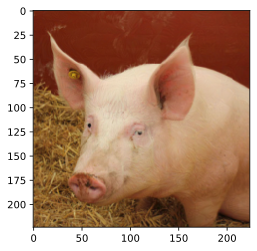

In [25]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

And here is our airliner noise.

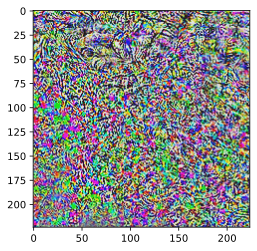

In [26]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

reference: https://adversarial-ml-tutorial.org/introduction/